In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# eigen decomposition for the JC69 model
evec = np.array([
1.0, 2.0, 0.0, 0.5, 1.0, -2.0, 0.5, 0.0, 1.0, 2.0, 0.0, -0.5, 1.0, -2.0, -0.5, 0.0
])

ivec = np.array([
0.25, 0.25, 0.25, 0.25, 0.125, -0.125, 0.125, -0.125, 0.0, 1.0, 0.0,
-1.0, 1.0, 0.0, -1.0, 0.0
])

evalues = np.array(
[0.0, -1.3333333333333333, -1.3333333333333333, -1.3333333333333333])

freqs = np.full((4,), 0.25)

def JC69_p_t(d):
    return evec.reshape((4, 4)) @ (np.expand_dims(np.exp(evalues*d), axis=-1)*np.eye(4)) @ ivec.reshape((4, 4))

seq_length = 100000
seq1 = np.random.choice(np.arange(4), seq_length, p=freqs)
seq2 = []
mats = JC69_p_t(0.1)

for i in range(seq_length):
    probs = mats[seq1[i],]
    seq2.append(np.random.choice(np.arange(4), 1, p=probs))
seq2 = np.concatenate(seq2)

dna_map = [
    [1.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0],
    [0.0, 0.0, 0.0, 1.0],
]

def calculate_log_prob(partial1, partial2, weights, edge_lengths):
    bls = np.expand_dims(edge_lengths, axis=1)
    mats = JC69_p_t(bls)
    partial = partial2 * (np.matmul(mats, partial1))
    return np.sum(np.log(np.matmul(freqs, partial)) * weights, axis=-1)

weights = np.ones(seq_length)

partial1 = np.transpose(np.array([dna_map[nuc] for nuc in seq1]))
partial2 = np.transpose(np.array([dna_map[nuc] for nuc in seq2]))


Bad key "text.kerning_factor" on line 4 in
/Users/mathieu/miniconda3/envs/bito/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


desc           MLE                  log likelihood
normal         0.09900000000000007 -179758.58889889996
unknown=4x1    0.09900000000000007 -175598.70286636864
unknown=4x0.5  0.09900000000000007 -182530.17467196807 -6931.471805599431
1=0.5          0.09900000000000007 -186690.06070449942 -6931.47180559946
1=0.9 0=0.1    0.09200000000000007 -179274.96055478242
1=0.8 0=0.2    0.09300000000000007 -179688.35710848728
1=0.8 0=0.2/3  0.09300000000000007 -180683.51927480707
1=0.6 0=0.4    0.09600000000000007 -181355.27502459518
1=0.6 0=0.4/3  0.09200000000000007 -182687.21522299806


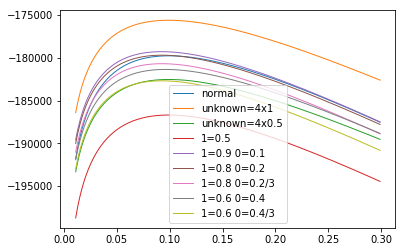

In [2]:
print('desc'.ljust(14), 'MLE'.ljust(20),'log likelihood')

branch_lengths = np.arange(0.011, 0.3, 0.001)
logps = calculate_log_prob(partial1, partial2, weights, branch_lengths)
plt.plot(branch_lengths, logps, linewidth=1.0, label='normal')
idx = np.argmax(logps)
print('normal'.ljust(14), branch_lengths[idx], logps[idx])

# A proportion of partials are going to be changed
prop =  0.1

# Set a proportion of partials as unknown (i.e. [1,1,1,1])
partial3 = np.concatenate((np.ones((4, int(seq_length*prop))), partial2[:,int(seq_length*prop):]), -1)
logps2 = calculate_log_prob(partial1, partial3, weights, branch_lengths)
plt.plot(branch_lengths, logps2, linewidth=1.0, label='unknown=4x1')
idx = np.argmax(logps2)
print('unknown=4x1'.ljust(14), branch_lengths[idx], logps2[idx])

# Set a proportion of partials as [0.5,0.5,0.5,0.5])
partial3 = partial2.copy()
partial3[:,:int(seq_length*prop)] = 0.5
logps3 = calculate_log_prob(partial1, partial3, weights, branch_lengths)
plt.plot(branch_lengths, logps3, linewidth=1.0, label='unknown=4x0.5')
idx = np.argmax(logps3)
print('unknown=4x0.5'.ljust(14), branch_lengths[idx], logps3[idx], (logps3[idx]-logps2[idx]))

# Replace ones with 0.5 in a some partials
partial3 = partial2.copy()
partial3[:,:int(seq_length*prop)] *= 0.5
logps4 = calculate_log_prob(partial1, partial3, weights, branch_lengths)
plt.plot(branch_lengths, logps4, linewidth=1.0, label='1=0.5')
idx = np.argmax(logps4)
print('1=0.5'.ljust(14), branch_lengths[idx], logps4[idx], (logps4[idx]-logps[idx]))

# Replace ones with 0.9 and zeros with 0.1 in a some partials
partial3 = partial2.copy()
partial3[:,:int(seq_length*prop)] = (1.0-partial2[:,:int(seq_length*prop)]) * 0.1 + partial2[:,:int(seq_length*prop)] * 0.9
logps2 = calculate_log_prob(partial1, partial3, weights, branch_lengths)
plt.plot(branch_lengths, logps2, linewidth=1.0, label='1=0.9 0=0.1')
idx = np.argmax(logps2)
print('1=0.9 0=0.1'.ljust(14), branch_lengths[idx], logps2[idx])

# Replace ones with 0.8 and zeros with 0.2 in a some partials
partial3 = partial2.copy()
partial3[:,:int(seq_length*prop)] = (1.0-partial2[:,:int(seq_length*prop)]) * 0.2 + partial2[:,:int(seq_length*prop)] * 0.8
logps2 = calculate_log_prob(partial1, partial3, weights, branch_lengths)
plt.plot(branch_lengths, logps2, linewidth=1.0, label='1=0.8 0=0.2')
idx = np.argmax(logps2)
print('1=0.8 0=0.2'.ljust(14), branch_lengths[idx], logps2[idx])

# Replace ones with 0.8 and zeros with 0.2/3 in a some partials
partial3 = partial2.copy()
partial3[:,:int(seq_length*prop)] = (1.0-partial2[:,:int(seq_length*prop)]) * 0.2/3 + partial2[:,:int(seq_length*prop)] * 0.8
logps2 = calculate_log_prob(partial1, partial3, weights, branch_lengths)
plt.plot(branch_lengths, logps2, linewidth=1.0, label='1=0.8 0=0.2/3')
idx = np.argmax(logps2)
print('1=0.8 0=0.2/3'.ljust(14), branch_lengths[idx], logps2[idx])

# Replace ones with 0.6 and zeros with 0.4 in a some partials
partial3 = partial2.copy()
partial3[:,:int(seq_length*prop)] = (1.0-partial2[:,:int(seq_length*prop)]) * 0.4 + partial2[:,:int(seq_length*prop)] * 0.6
logps2 = calculate_log_prob(partial1, partial3, weights, branch_lengths)
plt.plot(branch_lengths, logps2, linewidth=1.0, label='1=0.6 0=0.4')
idx = np.argmax(logps2)
print('1=0.6 0=0.4'.ljust(14), branch_lengths[idx], logps2[idx])

# Replace ones with 0.6 and zeros with 0.4/3 in a some partials
partial3 = partial2.copy()
partial3[:,:int(seq_length*prop)] = (1.0-partial2[:,:int(seq_length*prop)]) * 0.4/3 + partial2[:,:int(seq_length*prop)] * 0.6
logps2 = calculate_log_prob(partial1, partial3, weights, branch_lengths)
plt.plot(branch_lengths, logps2, linewidth=1.0, label='1=0.6 0=0.4/3')
idx = np.argmax(logps2)
print('1=0.6 0=0.4/3'.ljust(14), branch_lengths[idx], logps2[idx])

plt.legend()
plt.show()